<a href="https://colab.research.google.com/github/Mr-SuSeL/NeuralNetworkPredictsDowJones/blob/main/Projekt_Sieci_Neuronowe_PrognozaKursuAkcji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
stocks = 'https://raw.githubusercontent.com/HSanaei/MachineLearing/main/19880101_20191231.csv'
data_raw = pd.read_csv(stocks, index_col='Date')

In [2]:
def generate_features(df):
    """
    Generate features for a stock/index based on historical price and performance
    @param df: dataframe with columns "Open", "Close", "High", "Low", "Volume", "Adjusted Close"
    @return: dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    # 6 original features
    df_new['open'] = df['Open']
    df_new['open_1'] = df['Open'].shift(1)
    df_new['close_1'] = df['Close'].shift(1)
    df_new['high_1'] = df['High'].shift(1)
    df_new['low_1'] = df['Low'].shift(1)
    df_new['volume_1'] = df['Volume'].shift(1)
    # 31 generated features
    # average price
    df_new['avg_price_5'] = df['Close'].rolling(5).mean().shift(1)
    df_new['avg_price_30'] = df['Close'].rolling(21).mean().shift(1)
    df_new['avg_price_365'] = df['Close'].rolling(252).mean().shift(1)
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    # average volume
    df_new['avg_volume_5'] = df['Volume'].rolling(5).mean().shift(1)
    df_new['avg_volume_30'] = df['Volume'].rolling(21).mean().shift(1)
    df_new['avg_volume_365'] = df['Volume'].rolling(252).mean().shift(1)
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    # standard deviation of prices
    df_new['std_price_5'] = df['Close'].rolling(5).std().shift(1)
    df_new['std_price_30'] = df['Close'].rolling(21).std().shift(1)
    df_new['std_price_365'] = df['Close'].rolling(252).std().shift(1)
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']
    # standard deviation of volumes
    df_new['std_volume_5'] = df['Volume'].rolling(5).std().shift(1)
    df_new['std_volume_30'] = df['Volume'].rolling(21).std().shift(1)
    df_new['std_volume_365'] = df['Volume'].rolling(252).std().shift(1)
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    # # return
    df_new['return_1'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)).shift(1)
    df_new['return_365'] = ((df['Close'] - df['Close'].shift(252)) / df['Close'].shift(252)).shift(1)
    df_new['moving_avg_5'] = df_new['return_1'].rolling(5).mean().shift(1)
    df_new['moving_avg_30'] = df_new['return_1'].rolling(21).mean().shift(1)
    df_new['moving_avg_365'] = df_new['return_1'].rolling(252).mean().shift(1)
    # the target
    df_new['close'] = df['Close']
    df_new = df_new.dropna(axis=0)
    return df_new

In [3]:
data = generate_features(data_raw)

start_train = '1988-01-01'
end_train = '2018-12-31'

start_test = '2019-01-01'
end_test = '2019-12-31'


In [4]:
data_train = data.loc[start_train:end_train]
X_train = data_train.drop('close', axis=1).values
y_train = data_train['close'].values


data_test = data.loc[start_test:end_test]
X_test = data_test.drop('close', axis=1).values
y_test = data_test['close'].values

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [7]:
tf.random.set_seed(42)


model = Sequential([
    Dense(units=32, activation='relu'),
    Dense(units=1)
])


model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.1))

model.fit(X_scaled_train, y_train, epochs=100, verbose=True)


Epoch 1/100
205/205 [==============================] - 6s 9ms/step - loss: 42383300.0000
Epoch 2/100
205/205 [==============================] - 1s 5ms/step - loss: 3270327.7500
Epoch 3/100
205/205 [==============================] - 1s 6ms/step - loss: 1435519.1250
Epoch 4/100
205/205 [==============================] - 2s 8ms/step - loss: 674281.0000
Epoch 5/100
205/205 [==============================] - 0s 2ms/step - loss: 312494.0312
Epoch 6/100
205/205 [==============================] - 2s 12ms/step - loss: 168814.6562
Epoch 7/100
205/205 [==============================] - 0s 2ms/step - loss: 98795.1094
Epoch 8/100
205/205 [==============================] - 2s 11ms/step - loss: 70305.7656
Epoch 9/100
205/205 [==============================] - 0s 2ms/step - loss: 52656.0859
Epoch 10/100
205/205 [==============================] - 1s 6ms/step - loss: 42340.1094
Epoch 11/100
205/205 [==============================] - 2s 12ms/step - loss: 42374.0156
Epoch 12/100
205/205 [=================

In [8]:
predictions = model.predict(X_scaled_test)[:, 0]

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(f'MSE: {mean_squared_error(y_test, predictions):.3f}')
print(f'MAE: {mean_absolute_error(y_test, predictions):.3f}')
print(f'R^2: {r2_score(y_test, predictions):.3f}')

8/8 [==============================] - 0s 37ms/step
MSE: 53719.024
MAE: 182.470
R^2: 0.953


In [9]:
model = Sequential([
    Dense(units=16, activation='relu'),
    Dense(units=1)
])

model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.21))

model.fit(X_scaled_train, y_train, epochs=1000, verbose=False)

predictions = model.predict(X_scaled_test)[:, 0]


8/8 [==============================] - 1s 119ms/step


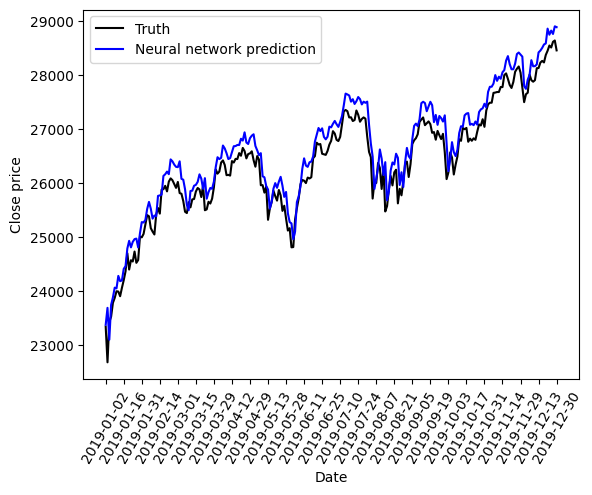

In [10]:
import matplotlib.pyplot as plt
plt.plot(data_test.index, y_test, c='k')
plt.plot(data_test.index, predictions, c='b')
#plt.plot(data_test.index, predictions, c='r')
#plt.plot(data_test.index, predictions, c='g')
plt.xticks(range(0, 252, 10), rotation=60)
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(['Truth', 'Neural network prediction'])
plt.show()

In [11]:
# Porównanie z inną metodą - SVR: regresja wektorów nośnych z
# jądrem liniowym i radialną funkcją bazową
param_grid = [
    {'kernel':['linear'], 'C': [100, 300, 500],
     'epsilon': [0.00003, 0.0001]},
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                'C': [10, 100, 1000], 'epsilon': [0.00003, 0.0001]}
]

In [12]:
from sklearn.svm import SVR
svr = SVR()

In [13]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2')
grid_search.fit(X_scaled_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [100, 300, 500], 'epsilon': [3e-05, 0.0001],
                          'kernel': ['linear']},
                         {'C': [10, 100, 1000], 'epsilon': [3e-05, 0.0001],
                          'gamma': [0.001, 0.0001], 'kernel': ['rbf']}],
             scoring='r2')

In [15]:
print(grid_search.best_params_)

{'C': 500, 'epsilon': 0.0001, 'kernel': 'linear'}


In [16]:
svr_best = grid_search.best_estimator_
predictions_svr = svr_best.predict(X_scaled_test)
print(f'Błąd średniokwadratowy: {mean_squared_error(y_test, predictions_svr):.3f}')

Błąd średniokwadratowy: 29472.031


In [17]:
print(f'Błąd bezwględny: {mean_absolute_error(y_test, predictions_svr):.3f}')

Błąd bezwględny: 122.525


In [18]:
print(f'R^2: {r2_score(y_test, predictions_svr):.3f}')

R^2: 0.974


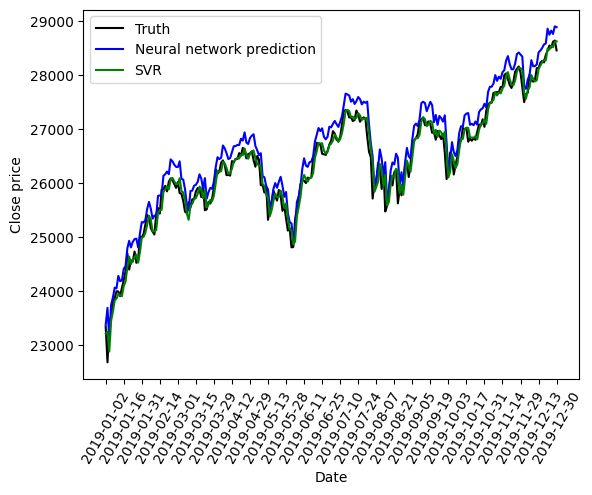

In [19]:
plt.plot(data_test.index, y_test, c='k')
plt.plot(data_test.index, predictions, c='b')
plt.plot(data_test.index, predictions_svr, c='g')
plt.xticks(range(0, 252, 10), rotation=60)
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(['Truth', 'Neural network prediction', 'SVR'])
plt.show()